# Unlocking Church Growth: Data Insights from the National Congregations Study
# Worship Service Analysis

## Objective
In this segment of the analysis we specifically explore the features associated to the Worship Service of the congregation and how they may impact an attendance change. The features included are:<br>
 - Services: The number of services per week
 - Lenght: length of service in minutes
 - Sermon: was a sermon involved in the worship service?
 - Sermon Time: length of the sermon in minutes
 - Podium: did the speaker come down off the altar, podium, chancel, or stage during hte sermon?
 - Unique Speakers: how many unique speakers were there?
 - Greetings: Was time allocated for greetings, handshaking, etc. during the service?
 - Kids: was a part of the service specifically for children?
 - Teens: were any speaking, singing, or performing parts specifically for teens in the service?
 - Robe: did the clergy leader wear a robe?
 - Applause: was there applause during any point of the service?
 - Laughing: was laughing invoked during the service?
 - Bulletin: was a program, bulletin, or other written order of service distributed?
 - Streamed: was the service broadcast or streamed live?
 - Smartphone: were people offered the opportunity to use their smartphones to participate in some way?
 - Congregational Reading: did hte congregation speak, read, or recite something together at any point?
 - Offering: was a monetary offering collected during the service?
 - Social Time: how long did people mingle informally before and after the service in minutes?

## Data Preparation

In [50]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from scipy.stats import spearmanr, pearsonr, chi2_contingency, fisher_exact
from scipy.stats.contingency import relative_risk
from scipy.stats.contingency import odds_ratio
from scipy.stats import f_oneway  # Inferential Analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Rancom Forest oversampling
import itertools
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import pointbiserialr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


# Import DictionaryCollection class from Dictionaries.py
    # Download the file from GitHub
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/notebook/dictionaries.py'
response = requests.get(url)

    # Save the file locally
with open('dictionaries.py', 'wb') as file:
    file.write(response.content)
from dictionaries import dictionaryCollection

In [2]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

In [3]:
# Initialize DictionaryCollection instance
dict_collection = dictionaryCollection()

# Replace numerical values column with string values from dictionaries
data = dict_collection.replace_numeric_values(data)

In [4]:
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

### Data Transformations

In [5]:
# Create new features based on conditions
data['change_category'] = data['CHANGE'].apply(
    lambda x: "Increase" if "Increased" in str(x) else ("Decrease" if "Decreased" in str(x) else ("Same" if "Same" in str(x) else "Same"))
)

# Change column data types
data['DENOM'] = data['DENOM'].astype('category')
data['change_category'] = data['change_category'].astype('category')

### Data Cleaning

In [6]:
# Select specific features
selected_columns = ['DENOM', 'NUMSERV1', 'LENGTH', 'SERMON', 'SERMTIME', 'SPKRDWN', 'NUMSPOKE', 'GREET', 'KIDTIME', 'TEENPART', 'ROBE', 'APPLAUSE', 'LAUGH', 'PROGRAM', 'OVERHEAD', 'STREAMED', 'SMTPHONE', 'CONGREAD', 'OFFERING', 'SOCLTIME', 'change_category']
df_worship = data[selected_columns].copy()

In [7]:
# Drop DENOM
df_worship.drop(['DENOM'], axis=1, inplace=True)

# One-Hot Encoding
categorical_columns = df_worship.select_dtypes(include=['category']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_worship[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
df_worship_encoded = pd.concat([df_worship, encoded_df], axis=1)
df_worship_encoded = df_worship_encoded.drop(categorical_columns, axis=1)

## Descriptive Analysis

In [8]:
# Basic exploration
df_worship.info()
df_worship.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   NUMSERV1         5322 non-null   float64 
 1   LENGTH           5321 non-null   float64 
 2   SERMON           5326 non-null   object  
 3   SERMTIME         5289 non-null   float64 
 4   SPKRDWN          2777 non-null   object  
 5   NUMSPOKE         1215 non-null   float64 
 6   GREET            5326 non-null   object  
 7   KIDTIME          1232 non-null   object  
 8   TEENPART         1232 non-null   object  
 9   ROBE             4095 non-null   object  
 10  APPLAUSE         5320 non-null   object  
 11  LAUGH            1228 non-null   object  
 12  PROGRAM          5330 non-null   object  
 13  OVERHEAD         5326 non-null   object  
 14  STREAMED         1254 non-null   object  
 15  SMTPHONE         1255 non-null   object  
 16  CONGREAD         2737 non-null   object  


,NUMSERV1,LENGTH,SERMTIME,NUMSPOKE,SOCLTIME
count,5322.000000,5321.000000,5289.000000,1215.000000,4054.000000
mean,5.616967,81.415899,25.555493,3.688889,32.827578
std,28.010125,38.381398,20.816414,5.416309,26.042180
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,60.000000,15.000000,2.000000,15.000000
50%,3.000000,70.000000,20.000000,3.000000,30.000000
75%,7.000000,90.000000,35.000000,4.000000,40.000000
max,2000.000000,1440.000000,600.000000,125.000000,600.000000


## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

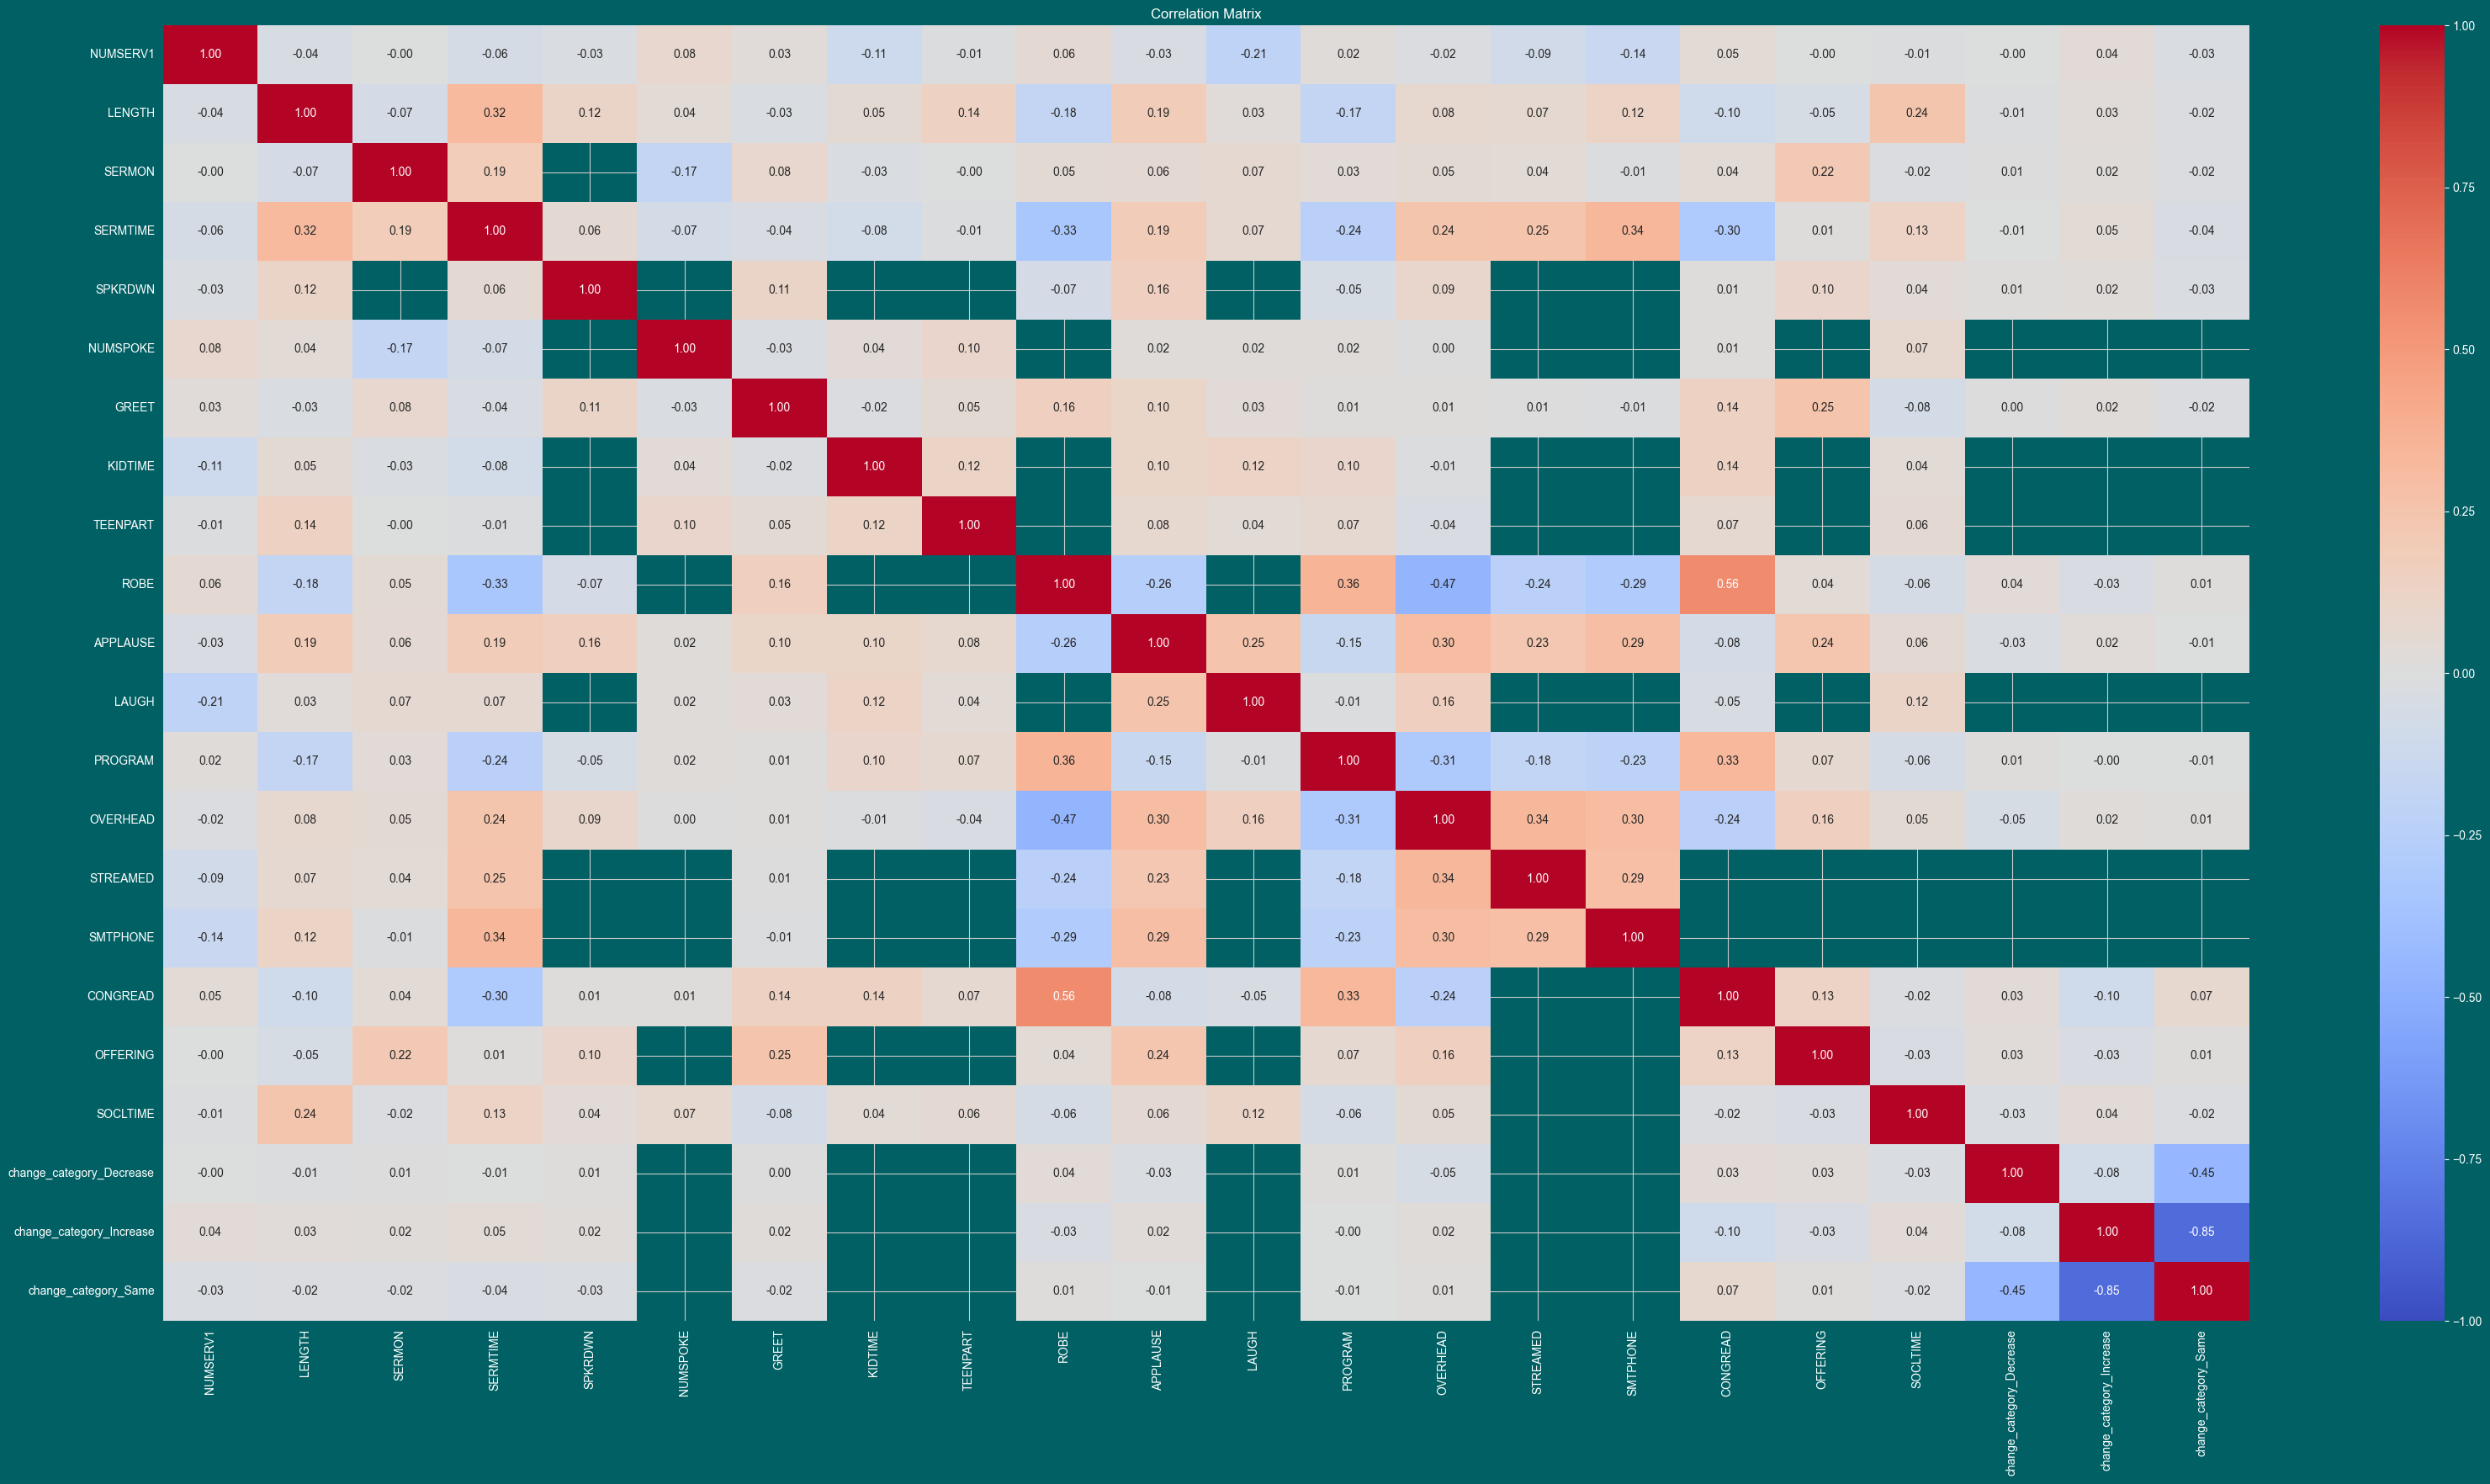

In [9]:
# Perform correlation analysis
correlation_matrix = df_worship_encoded.corr()

plt.figure(figsize=(40,20))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Add plot title and show plot
plt.title('Correlation Matrix')
plt.show()

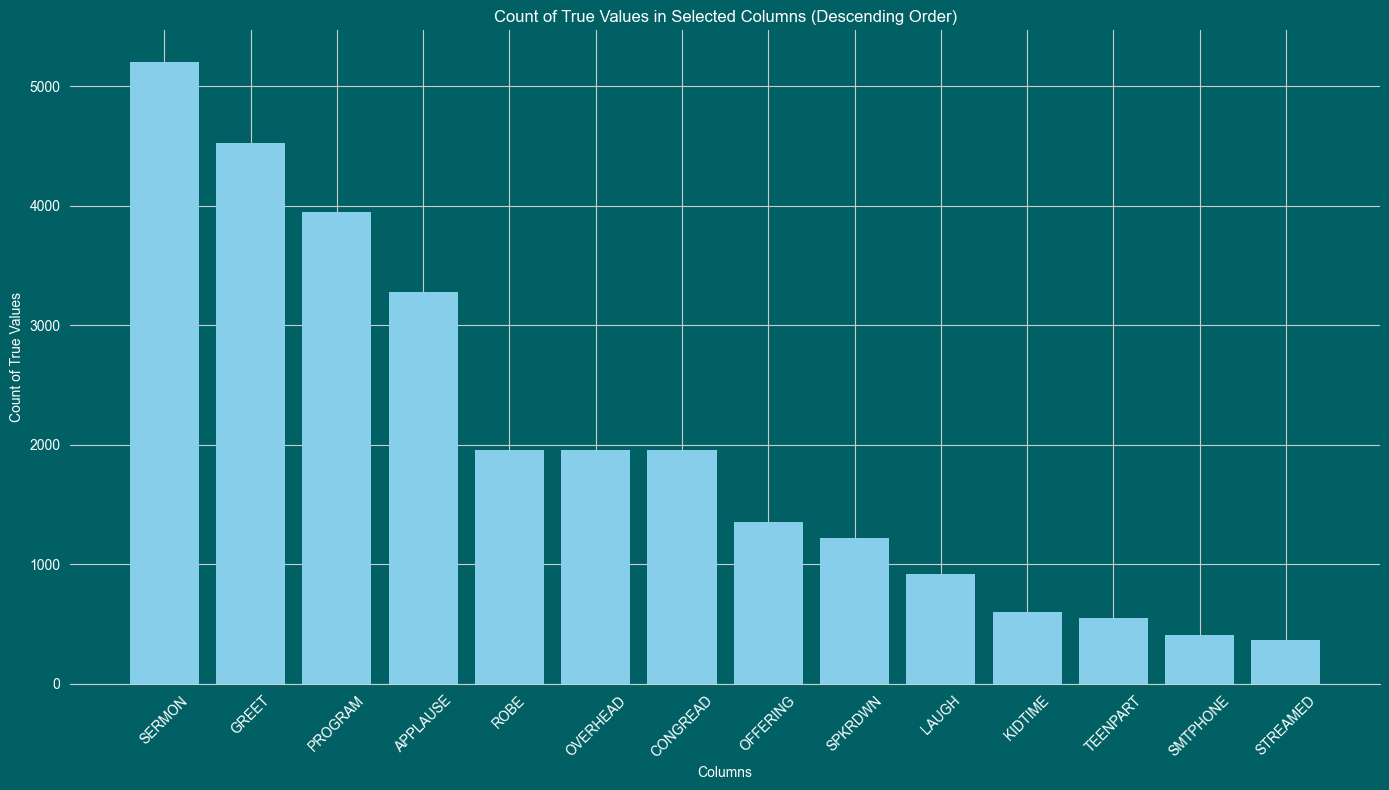

In [10]:
# Specify columns of interest
columns_of_interest = ['SERMON', 'SPKRDWN', 'GREET', 'KIDTIME', 'TEENPART', 'ROBE', 'APPLAUSE', 'LAUGH', 'PROGRAM', 'OVERHEAD', 'STREAMED', 'SMTPHONE', 'CONGREAD', 'OFFERING']

# Count True values for each column
counts = {col: df_worship_encoded[col].sum() for col in columns_of_interest}

# Sort counts in descending order
sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

# Plot counts for each column as multiple bars in one graph
plt.figure(figsize=(14, 8))

# Create the bar plot with sorted counts
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue')

# Adding labels and title
plt.xlabel('Columns')
plt.ylabel('Count of True Values')
plt.title('Count of True Values in Selected Columns (Descending Order)')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

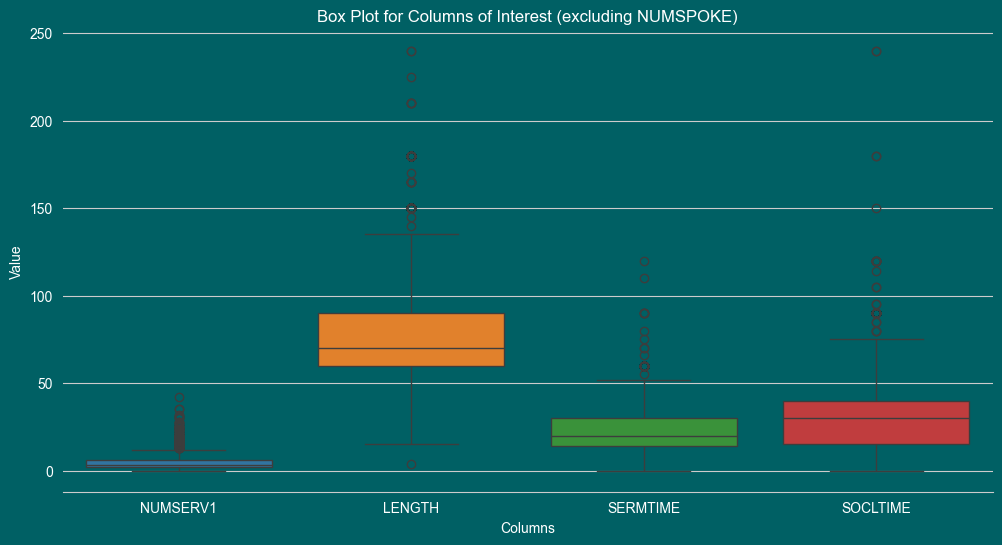

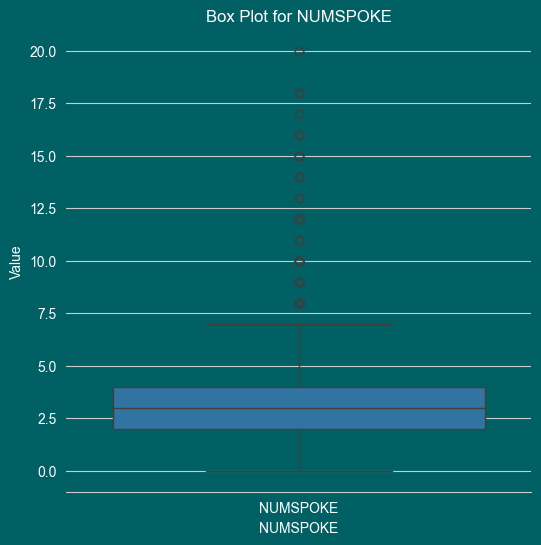

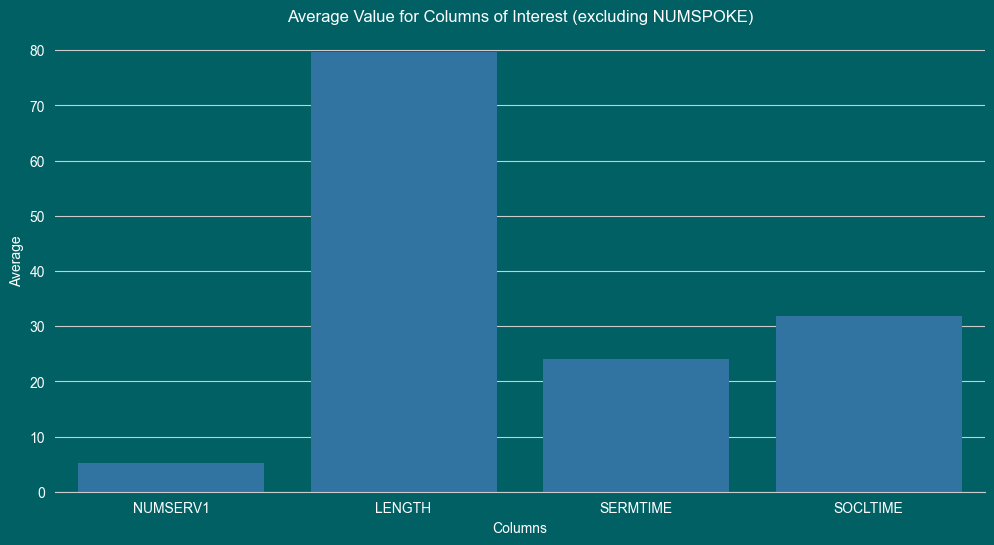

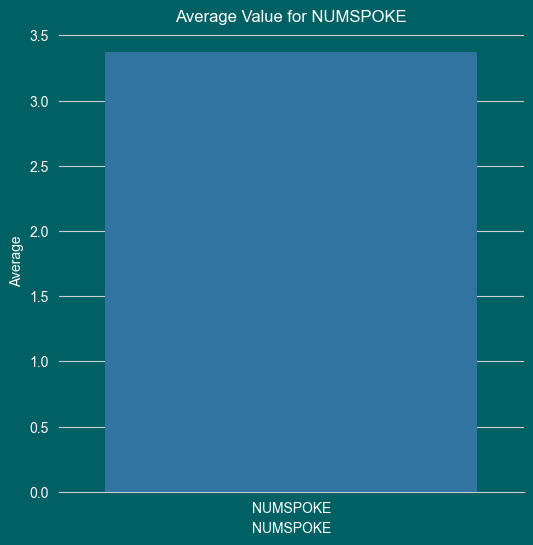

In [18]:
# Columns of interest
columns_of_interest = ['NUMSERV1', 'LENGTH', 'SERMTIME', 'NUMSPOKE', 'SOCLTIME']

# Drop rows where any column of interest has a value greater than 250
df_filtered = df_worship_encoded[(df_worship_encoded[columns_of_interest] <= 250).all(axis=1)]

# Further drop rows where NUMSPOKE is greater than 20
df_filtered = df_filtered[df_filtered['NUMSPOKE'] <= 20]

# Calculate statistics for the filtered DataFrame
statistics_filtered = df_filtered[columns_of_interest].agg(['min', 'max', 'median', 'mean'])

# Separate NUMSPOKE
columns_without_numspoke = ['NUMSERV1', 'LENGTH', 'SERMTIME', 'SOCLTIME']

# Box plot for columns without NUMSPOKE
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered[columns_without_numspoke])
plt.title('Box Plot for Columns of Interest (excluding NUMSPOKE)')
plt.ylabel('Value')
plt.xlabel('Columns')
plt.show()

# Box plot for NUMSPOKE
plt.figure(figsize=(6, 6))
sns.boxplot(data=df_filtered[['NUMSPOKE']])
plt.title('Box Plot for NUMSPOKE')
plt.ylabel('Value')
plt.xlabel('NUMSPOKE')
plt.show()

# Bar plot for average without NUMSPOKE
plt.figure(figsize=(12, 6))
sns.barplot(x=columns_without_numspoke, y=statistics_filtered.loc['mean'][columns_without_numspoke])
plt.title('Average Value for Columns of Interest (excluding NUMSPOKE)')
plt.ylabel('Average')
plt.xlabel('Columns')
plt.show()

# Bar plot for average of NUMSPOKE
plt.figure(figsize=(6, 6))
sns.barplot(x=['NUMSPOKE'], y=[statistics_filtered.loc['mean']['NUMSPOKE']])
plt.title('Average Value for NUMSPOKE')
plt.ylabel('Average')
plt.xlabel('NUMSPOKE')
plt.show()

In [19]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1169 entries, 2068 to 3563
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NUMSERV1                  1169 non-null   float64
 1   LENGTH                    1169 non-null   float64
 2   SERMON                    1166 non-null   object 
 3   SERMTIME                  1169 non-null   float64
 4   SPKRDWN                   0 non-null      object 
 5   NUMSPOKE                  1169 non-null   float64
 6   GREET                     1168 non-null   object 
 7   KIDTIME                   1167 non-null   object 
 8   TEENPART                  1167 non-null   object 
 9   ROBE                      0 non-null      object 
 10  APPLAUSE                  1165 non-null   object 
 11  LAUGH                     1164 non-null   object 
 12  PROGRAM                   1169 non-null   object 
 13  OVERHEAD                  1168 non-null   object 
 14  STREAMED  

## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

In [32]:
# Chi-Square Test
for col in df_worship_encoded.columns:
    if col != 'change_category':
        contingency_table = pd.crosstab(df_worship_encoded[col], df_worship_encoded['change_category'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f'Feature: {col}, p-value: {p}')

Feature: NUMSERV1, p-value: 0.040859636740502664
Feature: LENGTH, p-value: 0.010845463514413983
Feature: SERMON, p-value: 0.29418723261080665
Feature: SERMTIME, p-value: 0.0009741374437305764
Feature: SPKRDWN, p-value: 0.40090644592427244
Feature: NUMSPOKE, p-value: 1.0
Feature: GREET, p-value: 0.4755162193440621
Feature: KIDTIME, p-value: 1.0
Feature: TEENPART, p-value: 1.0
Feature: ROBE, p-value: 0.01021666955330299
Feature: APPLAUSE, p-value: 0.05050299141565173
Feature: LAUGH, p-value: 1.0
Feature: PROGRAM, p-value: 0.5764923038952268
Feature: OVERHEAD, p-value: 0.00016057156312468732
Feature: STREAMED, p-value: 1.0
Feature: SMTPHONE, p-value: 1.0
Feature: CONGREAD, p-value: 1.5990171373123274e-06
Feature: OFFERING, p-value: 0.40783706608671844
Feature: SOCLTIME, p-value: 1.3079281222886268e-05
Feature: change_category_Decrease, p-value: 0.0
Feature: change_category_Increase, p-value: 0.0
Feature: change_category_Same, p-value: 0.0


In [33]:
# ANOVA Test
numerical_columns = df_worship_encoded.select_dtypes(include=['float64']).columns.tolist()
for col in numerical_columns:
    groups = [df_worship_encoded[df_worship_encoded['change_category'] == cat][col] for cat in df_worship_encoded['change_category'].cat.categories]
    f_stat, p_value = f_oneway(*groups)
    print(f'Feature: {col}, p-value: {p_value}')

Feature: NUMSERV1, p-value: nan
Feature: LENGTH, p-value: nan
Feature: SERMTIME, p-value: nan
Feature: NUMSPOKE, p-value: nan
Feature: SOCLTIME, p-value: nan
Feature: change_category_Decrease, p-value: 0.0
Feature: change_category_Increase, p-value: 0.0
Feature: change_category_Same, p-value: 0.0


c:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [43]:
# Separate numerical columns
numerical_columns = df_worship_encoded.select_dtypes(include=['float64']).columns.tolist()

# Separate categorical columns
categorical_columns = df_worship_encoded.select_dtypes(include=['category']).columns.tolist()

# Impute NaNs in numerical columns with mean
df_worship_encoded_clean = df_worship_encoded.copy()
df_worship_encoded_clean[numerical_columns] = df_worship_encoded_clean[numerical_columns].fillna(df_worship_encoded[numerical_columns].mean())

# Drop rows with NaNs in categorical columns
df_worship_encoded_clean = df_worship_encoded_clean.dropna(subset=categorical_columns)

# Run Correlation Analysis
for col in numerical_columns:
    correlation, p_value = pointbiserialr(df_worship_encoded_clean['change_category'].cat.codes, df_worship_encoded_clean[col])
    print(f'Feature: {col}, Correlation: {correlation}, p-value: {p_value}')

Feature: NUMSERV1, Correlation: -0.021276941888081703, p-value: 0.12027718523242628
Feature: LENGTH, Correlation: -0.01075323606023378, p-value: 0.43238356499483543
Feature: SERMTIME, Correlation: -0.024864019719791425, p-value: 0.06943028852464726
Feature: NUMSPOKE, Correlation: -6.938893903907228e-18, p-value: 0.9999999999999996
Feature: SOCLTIME, Correlation: -0.00016675812689957213, p-value: 0.9902859503628461
Feature: change_category_Decrease, Correlation: -0.7360902354168429, p-value: 0.0
Feature: change_category_Increase, Correlation: -0.6134570524236446, p-value: 0.0
Feature: change_category_Same, Correlation: 0.935206548365429, p-value: 0.0


## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

In [53]:
# Encode Target Variable
df_worship_encoded['change_category'] = df_worship_encoded['change_category'].map({
    'Increase': 1,
    'Decrease': -1,
    'Same': 0
})


Missing values in features:
NUMSERV1                    0
LENGTH                      0
SERMON                      0
SERMTIME                    0
SPKRDWN                     0
NUMSPOKE                    0
GREET                       0
KIDTIME                     0
TEENPART                    0
ROBE                        0
APPLAUSE                    0
LAUGH                       0
PROGRAM                     0
OVERHEAD                    0
STREAMED                    0
SMTPHONE                    0
CONGREAD                    0
OFFERING                    0
SOCLTIME                    0
change_category_Decrease    0
change_category_Increase    0
change_category_Same        0
dtype: int64
Missing values in target variable:
0


ValueError: Found array with 0 sample(s) (shape=(0, 22)) while a minimum of 1 is required by SimpleImputer.

## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

In [ ]:
# Random Forest

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance)

In [ ]:
# Define the feature combinations to test
input_combinations = pd.DataFrame({
    'REMODEL': [1, 0, 1, 0, 1, 0, 0, 0],  # Test various combinations of 'yes' (1) and 'no' (0)
    'HOMESCHL': [1, 1, 0, 0, 1, 1, 0, 0],
    'HAVESCHL': [1, 1, 1, 1, 0, 0, 0, 0],
    # Add other features if needed; here we assume they are all zero
})

# Ensure all columns are present in the input combinations
for col in X_train.columns:
    if col not in input_combinations.columns:
        input_combinations[col] = 0

# Predict probabilities using the Random Forest model
predicted_probs = model.predict_proba(input_combinations)

# Convert predictions to a DataFrame for visualization
# The `model.classes_` should be ['decrease', 'increase', 'same'] or in a similar order
predicted_df = pd.DataFrame(predicted_probs, columns=model.classes_)
predicted_df['Combination'] = ['Remodel=Yes, Homeschl=Yes, Haveschl=Yes', 
                               'Remodel=No, Homeschl=Yes, Haveschl=Yes',
                               'Remodel=Yes, Homeschl=No, Haveschl=Yes',
                               'Remodel=No, Homeschl=No, Haveschl=Yes',
                               'Remodel=Yes, Homeschl=Yes, Haveschl=No',
                               'Remodel=No, Homeschl=Yes, Haveschl=No',
                               'Remodel=Yes, Homeschl=No, Haveschl=No',
                               'Remodel=No, Homeschl=No, Haveschl=No']

# Melt the DataFrame for easier plotting with seaborn
melted_df = pd.melt(predicted_df, id_vars='Combination', var_name='Change Category', value_name='Probability')

# Plotting the probabilities
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_df, x='Combination', y='Probability', hue='Change Category', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Probability')
plt.title('Predicted Probabilities for Change Category for Various Feature Combinations')
plt.tight_layout()
plt.legend(title='Change Category')
plt.show()

## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.